<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_4_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Source: https://github.com/DEAP/deap/blob/master/examples/ga/onemax_numpy.py

DEAP is free software: you can redistribute it and/or modify
   it under the terms of the GNU Lesser General Public License as
   published by the Free Software Foundation, either version 3 of
   the License, or (at your option) any later version.

   DEAP is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
   GNU Lesser General Public License for more details.
   You should have received a copy of the GNU Lesser General Public
   License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

In [ ]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 163kB 6.7MB/s 


In [ ]:
#@title Imports
import random
import array
import time

import numpy as np

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
#@title Hyperparameters
NDIM = 6
CR = 0.25
F = 1  
MU = 300
NGEN = 1000  
GEN_OUTPUT = 25
MAX_TIME = 5

In [ ]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

In [ ]:
#@title Add Genetic Operators to Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -3, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selRandom, k=3)

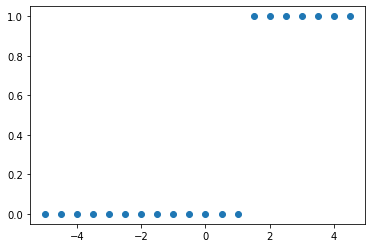

In [ ]:
#@title Generate regression data
equation_form = "step" #@param ["polynomial", "abs", "step"]

X_START = -5
X_END = 5
X_STEP = 0.5

def equation(x):
  if equation_form == "polynomial":
    return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10) 
  elif equation_form == "abs":    
    return abs(x)
  else:    
    return np.where(x>1, 1, 0)     

X = np.array([x for x in np.arange(X_START, X_END, X_STEP)])
Y = equation(X)
data = list(zip(X, Y))

plt.scatter(X,Y)

In [ ]:
import csv
with open('data.csv', 'w') as f:      
    # using csv.writer method from CSV package
    write = csv.writer(f)      
    write.writerows(data)

In [ ]:
#@title Evaluation of fitness
def pred(ind, x):    
  y_ = 0.0    
  for i in range(1,NDIM):
    y_ += ind[i-1]*x**i    
  y_ += ind[NDIM-1]       
  return y_

def fitness(ind, data):    
  mse = 0.0    
  for x, y in data:        
    y_ = pred(ind, x)
    mse += (y - y_)**2        
  return mse/len(data),

# fitness eval
toolbox.register("evaluate", fitness, data=data)

In [ ]:
#@title Plot Fitness
def plot_fitness(g, best, pop, logbook):
  Y_ = np.array([pred(best, x) for x in X])
  clear_output()
  print(f"Generation {g}, Best {best}") 
  print(logbook.stream)
  fits = [f.fitness.values[0] for f in pop]  
  plt.hist(fits)
  plt.show()
  plt.scatter(X,Y)
  plt.plot(X,Y_, 'r')
  plt.show()   

Generation 749, Best Individual('d', [-4270.163373473781, -2840.3755783572474, -366.76675319439596, 521.1126580908735, -8687.095296549971, -5292.73800286456, 296.2882872619894, -81.15843777770056, 58.94646822852273, 121.92223178223242, -7.831043088248254, -4.143751464044469, 2.3406741818840446, -0.08355947138178577, -0.10014941890732065, -661.5259092533579])
725	300  	1.83791e+16	3.53851e+14	1.61459e+16	1.54777e+17
726	300  	1.83795e+16	3.53851e+14	1.61407e+16	1.54777e+17
727	300  	1.83795e+16	3.53851e+14	1.61407e+16	1.54777e+17
728	300  	1.83796e+16	3.53851e+14	1.61325e+16	1.54777e+17
729	300  	1.83834e+16	3.53851e+14	1.60954e+16	1.54777e+17
730	300  	1.83838e+16	3.53851e+14	1.60948e+16	1.54777e+17
731	300  	1.83838e+16	3.53851e+14	1.60891e+16	1.54777e+17
732	300  	1.83816e+16	3.53851e+14	1.60853e+16	1.54754e+17
733	300  	1.83884e+16	3.53851e+14	1.60654e+16	1.54754e+17
734	300  	1.8378e+16 	3.53851e+14	1.60363e+16	1.54754e+17
735	300  	1.83843e+16	3.53851e+14	1.60178e+16	1.54754e+17
7

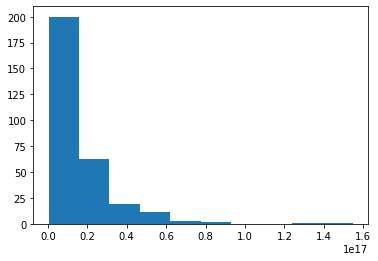

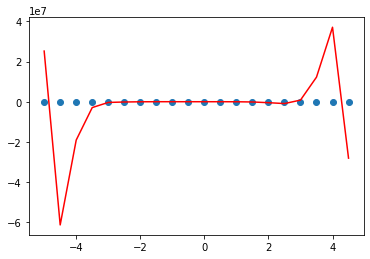

In [ ]:
pop = toolbox.population(n=MU);
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

# Evaluate the individuals
fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

record = stats.compile(pop)
logbook.record(gen=0, evals=len(pop), **record)
print(logbook.stream)
start = time.time()
for g in range(1, NGEN):
  for k, agent in enumerate(pop):
    a,b,c = toolbox.select(pop)
    y = toolbox.clone(agent)
    index = random.randrange(NDIM)
    for i, value in enumerate(agent):
      if i == index or random.random() < CR:
        y[i] = a[i] + F*(b[i]-c[i])
    y.fitness.values = toolbox.evaluate(y)
    if y.fitness > agent.fitness:
      pop[k] = y            
  hof.update(pop)    
  record = stats.compile(pop)
  logbook.record(gen=g, evals=len(pop), **record)
  if (g+1) % GEN_OUTPUT == 0:
    plot_fitness(g, hof[0], pop, logbook) 
    end = time.time()
    if end-start > MAX_TIME:
      break

print("Best individual is ", hof[0], hof[0].fitness.values[0])
